# Spark Linear Regression Model
- Attempting to predict used car price using linear regression from spark mllib 
- Dataset: https://www.kaggle.com/austinreese/craigslist-carstrucks-data#craigslistVehicles.csv

# Setting up environment

In [1]:
#Set proxies in container first. Installing pyspark for container. Restart kernel after. 
#
# ~/.condarc file contents
# proxy_servers:
#    http: http://web-proxy.corp.hpecorp.net:8080
#    https: http://web-proxy.corp.hpecorp.net:8080
# Run sudo conda install pyspark==2.3.1 in container 

In [2]:
%attachments

Training Cluster    ML Engine
------------------  -----------
sparktraining       spark


In [3]:
%%sparktraining --pyspark
import pyspark
print(pyspark.__version__)

2.3.1.dev0


In [4]:
import numpy as np
import pandas as pd 
import os
import json
import datetime 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark import SparkConf, SparkContext, SQLContext

conf = SparkConf().setAppName("test").setMaster("local")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

# Data exploration/preprocessing
- Only focusing on full.csv file 
- craigslistVehiclesFull.csv (26 columns)

In [5]:
vehicle_data_file_full = '/bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/craigslistVehiclesFull.csv'
vehicle_full_df = pd.read_csv(vehicle_data_file_full)
vehicle_full_df.head()

,url,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,...,paint_color,image_url,lat,long,county_fips,county_name,state_fips,state_code,state_name,weather
0,https://marshall.craigslist.org/cto/d/2010-dod...,marshall,11900,2010.0,dodge,challenger se,good,6 cylinders,gas,43600.0,...,red,https://images.craigslist.org/00i0i_2ggH1eKDNK...,43.4775,-96.7041,46083.0,Lincoln,46.0,SD,South Dakota,38.0
1,https://marshall.craigslist.org/cto/d/fleetwoo...,marshall,1515,1999.0,NaN,fleetwood,NaN,NaN,gas,NaN,...,NaN,https://images.craigslist.org/00M0M_irjh7SjEcU...,44.7612,-96.6907,46039.0,Deuel,46.0,SD,South Dakota,38.0
2,https://marshall.craigslist.org/cto/d/2008-for...,marshall,17550,2008.0,ford,f-150,NaN,NaN,gas,NaN,...,NaN,https://images.craigslist.org/00s0s_eL2XFhEUcx...,44.1415,-103.2052,46093.0,Meade,46.0,SD,South Dakota,38.0
3,https://marshall.craigslist.org/cto/d/ford-tau...,marshall,2800,2004.0,ford,taurus,good,6 cylinders,gas,168591.0,...,grey,https://images.craigslist.org/00L0L_5HUR1nQjt8...,43.2845,-95.5930,19143.0,Osceola,19.0,IA,Iowa,47.0
4,https://marshall.craigslist.org/cto/d/2001-gra...,marshall,400,2001.0,NaN,2001 Grand Prix,NaN,NaN,gas,217000.0,...,NaN,https://images.craigslist.org/00n0n_bJJ1XnonSG...,43.0261,-94.4064,19109.0,Kossuth,19.0,IA,Iowa,47.0


In [6]:
vehicle_full_df.describe()

,price,year,odometer,lat,long,county_fips,state_fips,weather
count,1.723065e+06,1.716750e+06,1.159011e+06,1.723065e+06,1.723065e+06,1.664232e+06,1.664232e+06,1.663637e+06
mean,1.075540e+05,2.004841e+03,1.136387e+05,3.878195e+01,-9.371198e+01,2.843053e+04,2.834410e+01,5.378706e+01
std,1.004439e+07,1.208772e+01,1.368603e+05,5.976412e+00,1.696519e+01,1.605423e+04,1.603224e+01,7.799381e+00
min,1.000000e+00,3.020000e+02,0.000000e+00,-8.481005e+01,-1.000000e+03,1.001000e+03,1.000000e+00,2.900000e+01
25%,3.295000e+03,2.002000e+03,5.800000e+04,3.491900e+01,-1.058010e+02,1.212300e+04,1.200000e+01,4.800000e+01
50%,7.000000e+03,2.007000e+03,1.070000e+05,3.940989e+01,-8.824070e+01,2.902100e+04,2.900000e+01,5.300000e+01
75%,1.499900e+04,2.012000e+03,1.520000e+05,4.255459e+01,-8.102650e+01,4.106700e+04,4.100000e+01,5.900000e+01
max,2.068627e+09,2.019000e+03,1.000000e+07,9.000000e+01,1.397061e+02,5.604500e+04,5.600000e+01,7.900000e+01


In [7]:
vehicle_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723065 entries, 0 to 1723064
Data columns (total 26 columns):
url             object
city            object
price           int64
year            float64
manufacturer    object
make            object
condition       object
cylinders       object
fuel            object
odometer        float64
title_status    object
transmission    object
vin             object
drive           object
size            object
type            object
paint_color     object
image_url       object
lat             float64
long            float64
county_fips     float64
county_name     object
state_fips      float64
state_code      object
state_name      object
weather         float64
dtypes: float64(7), int64(1), object(18)
memory usage: 341.8+ MB


# Initial cleaning steps
- Drop NaN rows
- Drop columns ('url', 'vin', 'image_url', 'lat', 'long', 'county_fips', 'state_fips', 'state_code', 'weather')
- Drop Odometer = 0 
- Clean up cylinders 
- Drop rows with type = 'other'
- Explore where prices are low numbers (ie single digits, potentially save for test set)

In [8]:
#Drop na rows
vehicle_full_df.dropna(inplace=True)
vehicle_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142330 entries, 3 to 1723064
Data columns (total 26 columns):
url             142330 non-null object
city            142330 non-null object
price           142330 non-null int64
year            142330 non-null float64
manufacturer    142330 non-null object
make            142330 non-null object
condition       142330 non-null object
cylinders       142330 non-null object
fuel            142330 non-null object
odometer        142330 non-null float64
title_status    142330 non-null object
transmission    142330 non-null object
vin             142330 non-null object
drive           142330 non-null object
size            142330 non-null object
type            142330 non-null object
paint_color     142330 non-null object
image_url       142330 non-null object
lat             142330 non-null float64
long            142330 non-null float64
county_fips     142330 non-null float64
county_name     142330 non-null object
state_fips      142330 non

In [9]:
#Dropping columns 
vehicle_full_df.drop(columns = ['url', 'vin', 'image_url', 'lat', 'long', 'county_fips', 'state_fips', 'state_code', 'weather'], inplace=True)
vehicle_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142330 entries, 3 to 1723064
Data columns (total 17 columns):
city            142330 non-null object
price           142330 non-null int64
year            142330 non-null float64
manufacturer    142330 non-null object
make            142330 non-null object
condition       142330 non-null object
cylinders       142330 non-null object
fuel            142330 non-null object
odometer        142330 non-null float64
title_status    142330 non-null object
transmission    142330 non-null object
drive           142330 non-null object
size            142330 non-null object
type            142330 non-null object
paint_color     142330 non-null object
county_name     142330 non-null object
state_name      142330 non-null object
dtypes: float64(2), int64(1), object(14)
memory usage: 19.5+ MB


In [10]:
#Deleting rows where odometer <= 1 
vehicle_full_df.drop(vehicle_full_df[vehicle_full_df.odometer <= 1].index, inplace=True)
vehicle_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141505 entries, 3 to 1723064
Data columns (total 17 columns):
city            141505 non-null object
price           141505 non-null int64
year            141505 non-null float64
manufacturer    141505 non-null object
make            141505 non-null object
condition       141505 non-null object
cylinders       141505 non-null object
fuel            141505 non-null object
odometer        141505 non-null float64
title_status    141505 non-null object
transmission    141505 non-null object
drive           141505 non-null object
size            141505 non-null object
type            141505 non-null object
paint_color     141505 non-null object
county_name     141505 non-null object
state_name      141505 non-null object
dtypes: float64(2), int64(1), object(14)
memory usage: 19.4+ MB


In [11]:
#Deleting type other 
vehicle_full_df.drop(vehicle_full_df[vehicle_full_df['type'] == 'other'].index, inplace=True)
vehicle_full_df.drop(vehicle_full_df[vehicle_full_df['cylinders'] == 'other'].index, inplace=True)

In [12]:
#Removing cyclinder string and converting to int
print(vehicle_full_df.cylinders.unique())
vehicle_full_df.cylinders = vehicle_full_df.cylinders.str.replace(' cylinders', '')
vehicle_full_df.cylinders = pd.to_numeric(vehicle_full_df.cylinders)
print(vehicle_full_df.cylinders.unique())                                

['6 cylinders' '4 cylinders' '8 cylinders' '5 cylinders' '10 cylinders'
 '12 cylinders' '3 cylinders']
[ 6  4  8  5 10 12  3]


In [13]:
vehicle_full_df.describe()

,price,year,cylinders,odometer
count,1.404480e+05,140448.000000,140448.000000,1.404480e+05
mean,4.615608e+04,2007.656706,6.136584,1.156818e+05
std,5.976161e+06,8.500170,1.651190,1.373079e+05
min,1.000000e+00,1900.000000,3.000000,2.000000e+00
25%,4.990000e+03,2005.000000,4.000000,6.700000e+04
50%,9.400000e+03,2009.000000,6.000000,1.092870e+05
75%,1.688000e+04,2013.000000,8.000000,1.501242e+05
max,1.234568e+09,2019.000000,12.000000,1.000000e+07


In [14]:
sorted(vehicle_full_df.odometer.unique())[:10]

[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]

In [15]:
vehicle_full_df.head(10)

,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,county_name,state_name
3,marshall,2800,2004.0,ford,taurus,good,6,gas,168591.0,clean,automatic,fwd,full-size,sedan,grey,Osceola,Iowa
140,reading,4480,2010.0,honda,insight,good,4,hybrid,110000.0,clean,automatic,fwd,mid-size,hatchback,silver,Berks,Pennsylvania
157,chambersburg,4500,2005.0,chevy,2500 hd,good,8,gas,204000.0,clean,automatic,rwd,full-size,truck,grey,Franklin,Pennsylvania
203,rapidcity,38500,2017.0,chevrolet,silverado,like new,8,gas,44710.0,clean,automatic,4wd,full-size,offroad,red,Custer,South Dakota
243,salina,800,2001.0,ford,escort zx2,fair,4,gas,93400.0,clean,automatic,fwd,compact,coupe,brown,Saline,Kansas
267,nd,1000,1999.0,chevy,blazer 4x4,good,6,gas,150000.0,clean,automatic,4wd,full-size,SUV,custom,Stutsman,North Dakota
277,nd,8800,2013.0,volkswagen,jetta,excellent,4,gas,65000.0,clean,manual,fwd,compact,sedan,grey,Ward,North Dakota
287,nd,15950,2015.0,chevy,equinox ltz,like new,4,gas,144707.0,clean,automatic,4wd,mid-size,SUV,white,Yellowstone,Montana
301,lascruces,4400,2009.0,hyundai,sonata,good,4,gas,99133.0,clean,automatic,fwd,mid-size,sedan,silver,Dona Ana,New Mexico
332,csd,10900,2007.0,gmc,1500 yukon,excellent,8,gas,138000.0,clean,automatic,fwd,full-size,SUV,silver,Meade,South Dakota


In [16]:
#Exploring low price numbers 
sorted(vehicle_full_df.price.unique())

[1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 25,
 29,
 30,
 32,
 35,
 38,
 40,
 44,
 45,
 48,
 50,
 55,
 59,
 60,
 69,
 71,
 79,
 91,
 99,
 100,
 123,
 125,
 135,
 144,
 150,
 152,
 175,
 177,
 178,
 179,
 180,
 187,
 188,
 189,
 193,
 194,
 195,
 199,
 200,
 205,
 208,
 209,
 211,
 217,
 219,
 221,
 222,
 225,
 226,
 227,
 228,
 229,
 232,
 233,
 234,
 239,
 241,
 244,
 247,
 249,
 250,
 252,
 255,
 259,
 262,
 263,
 264,
 266,
 267,
 269,
 273,
 275,
 276,
 277,
 279,
 281,
 283,
 284,
 285,
 286,
 287,
 289,
 292,
 293,
 295,
 299,
 300,
 301,
 306,
 309,
 310,
 311,
 312,
 318,
 323,
 325,
 326,
 327,
 329,
 332,
 340,
 344,
 350,
 353,
 355,
 359,
 363,
 365,
 370,
 374,
 375,
 380,
 384,
 385,
 388,
 395,
 398,
 399,
 400,
 425,
 427,
 449,
 450,
 455,
 457,
 463,
 475,
 486,
 488,
 489,
 495,
 499,
 500,
 509,
 511,
 512,
 522,
 525,
 550,
 555,
 575,
 590,
 594,
 595,
 598,
 599,
 600,
 625,
 640,
 642,
 649,
 650,
 675,
 680,
 69

In [17]:
low_price_vehicles = vehicle_full_df[vehicle_full_df['price'] < 800]
low_price_vehicles.head()

,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,county_name,state_name
2357,providence,1,2003.0,ford,truck,fair,8,gas,126000.0,clean,automatic,4wd,full-size,pickup,black,Kent,Rhode Island
2408,daytona,1,2015.0,bmw,4-series gran coupe,excellent,10,gas,55315.0,clean,other,4wd,compact,sedan,black,Orange,Florida
2411,daytona,1,2014.0,lexus,gs,excellent,10,gas,43100.0,clean,other,4wd,compact,sedan,grey,Orange,Florida
2834,eauclaire,550,1996.0,chevrolet,camaro,fair,6,gas,96010.0,clean,automatic,fwd,mid-size,coupe,purple,Eau Claire,Wisconsin
3252,minneapolis,1,2007.0,toyota,camry se,excellent,6,gas,210978.0,clean,automatic,fwd,mid-size,sedan,silver,Polk,Wisconsin


In [18]:
#Checking low odometer values also
vehicle_full_df[(vehicle_full_df['odometer'] <= 100) & (vehicle_full_df.year < 2017)]

,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,county_name,state_name
22747,nh,5500,2006.0,subaru,impreza sedan,excellent,4,gas,84.0,clean,automatic,4wd,mid-size,sedan,blue,Hillsborough,New Hampshire
29008,dallas,3800,2006.0,honda,accord ex v6,fair,6,gas,2.0,clean,automatic,fwd,mid-size,sedan,grey,Johnson,Texas
36034,milwaukee,12700,2016.0,chevy,malibu,new,4,gas,28.0,clean,automatic,fwd,full-size,sedan,black,Milwaukee,Wisconsin
39383,fargo,13500,2014.0,jeep,patriot,excellent,6,gas,74.0,clean,automatic,4wd,mid-size,SUV,black,Grand Forks,North Dakota
94452,nwct,5500,2000.0,ford,mustang gt,excellent,8,gas,85.0,clean,manual,rwd,compact,coupe,black,Fairfield,Connecticut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712544,asheville,8450,2007.0,buick,lacrosse cxl 4dr sedan,excellent,6,gas,6.0,clean,automatic,fwd,mid-size,sedan,white,Buncombe,North Carolina
1714878,boone,11,2015.0,toyota,camry,fair,4,gas,6.0,clean,automatic,rwd,full-size,sedan,brown,Alleghany,North Carolina
1716024,eastnc,45000,1971.0,chevrolet,camaro,new,8,gas,27.0,clean,manual,rwd,full-size,coupe,blue,Wayne,North Carolina
1717385,charlotte,15500,2008.0,mercedes-benz,s550,excellent,8,gas,97.0,clean,automatic,rwd,full-size,sedan,black,Mecklenburg,North Carolina


Findings: 
- Low odometers seems to be associated with new cars. But not all. Will drop all values with odometer <= 100 and before year 2017
- Some prices have low values. Will separate all cars with price < 800 into a dataset called Low_Price.csv (this can be used to generate predictions in our deployment cluster later)

In [19]:
#Dropping odometer <= 10 and year < 2017
vehicle_full_df = vehicle_full_df.drop(vehicle_full_df[(vehicle_full_df['odometer'] <= 100) & (vehicle_full_df.year < 2017)].index)
vehicle_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140208 entries, 3 to 1723064
Data columns (total 17 columns):
city            140208 non-null object
price           140208 non-null int64
year            140208 non-null float64
manufacturer    140208 non-null object
make            140208 non-null object
condition       140208 non-null object
cylinders       140208 non-null int64
fuel            140208 non-null object
odometer        140208 non-null float64
title_status    140208 non-null object
transmission    140208 non-null object
drive           140208 non-null object
size            140208 non-null object
type            140208 non-null object
paint_color     140208 non-null object
county_name     140208 non-null object
state_name      140208 non-null object
dtypes: float64(2), int64(2), object(13)
memory usage: 19.3+ MB


In [20]:
#Save low_price_vehicles dataframe to CSV then drop them for vehicle_full_df 
low_price_vehicles.to_csv('/bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/LowPrice.csv')
vehicle_full_df = vehicle_full_df[vehicle_full_df['price'] >= 800]
vehicle_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135971 entries, 3 to 1723064
Data columns (total 17 columns):
city            135971 non-null object
price           135971 non-null int64
year            135971 non-null float64
manufacturer    135971 non-null object
make            135971 non-null object
condition       135971 non-null object
cylinders       135971 non-null int64
fuel            135971 non-null object
odometer        135971 non-null float64
title_status    135971 non-null object
transmission    135971 non-null object
drive           135971 non-null object
size            135971 non-null object
type            135971 non-null object
paint_color     135971 non-null object
county_name     135971 non-null object
state_name      135971 non-null object
dtypes: float64(2), int64(2), object(13)
memory usage: 18.7+ MB


In [21]:
# Save cleaned files 
vehicle_full_df.to_csv('/bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/VehiclesFullCleaned.csv')

### Will use VehiclesFull dataset for model development

## Applying encoding to string values
- Ordinal for: condition, title_status, drive, size, type
- Label for: city, manufacturer, make, fuel, transmission, pain_color, county_name, state_name

In [22]:
vehicle_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135971 entries, 3 to 1723064
Data columns (total 17 columns):
city            135971 non-null object
price           135971 non-null int64
year            135971 non-null float64
manufacturer    135971 non-null object
make            135971 non-null object
condition       135971 non-null object
cylinders       135971 non-null int64
fuel            135971 non-null object
odometer        135971 non-null float64
title_status    135971 non-null object
transmission    135971 non-null object
drive           135971 non-null object
size            135971 non-null object
type            135971 non-null object
paint_color     135971 non-null object
county_name     135971 non-null object
state_name      135971 non-null object
dtypes: float64(2), int64(2), object(13)
memory usage: 18.7+ MB


## Factorizing to have integers start with 1

In [23]:
LabelEncoding = {}

vehicle_full_df.condition, condition_list = pd.factorize(vehicle_full_df['condition'])
vehicle_full_df.condition = vehicle_full_df.condition + 1

vehicle_full_df.title_status, title_list = pd.factorize(vehicle_full_df['title_status'])
vehicle_full_df.title_status = vehicle_full_df.title_status + 1

vehicle_full_df.drive, drive_list = pd.factorize(vehicle_full_df['drive'])
vehicle_full_df.drive = vehicle_full_df.drive + 1

vehicle_full_df.size, size_list = pd.factorize(vehicle_full_df['size'])
vehicle_full_df.size = vehicle_full_df.size + 1

vehicle_full_df.type, type_list = pd.factorize(vehicle_full_df['type'])
vehicle_full_df.type = vehicle_full_df.type + 1 

condition_mapping = { condition_list[i]:i+1 for i in range(len(condition_list)) }
title_mapping = {title_list[i]:i+1 for i in range(len(title_list))}
drive_mapping = {drive_list[i]:i+1 for i in range(len(drive_list))}
size_mapping = {size_list[i]:i+1 for i in range(len(size_list))}
type_mapping = {type_list[i]:i+1 for i in range(len(type_list))}

LabelEncoding['condition'] = condition_mapping
LabelEncoding['title_status'] = title_mapping
LabelEncoding['drive'] = drive_mapping
LabelEncoding['size'] = size_mapping
LabelEncoding['type'] = type_mapping

## Label encodings

In [24]:
#city label encoding
city_le = LabelEncoder() 
city_labels = city_le.fit_transform(vehicle_full_df.city) + 1
city_mappings = {label: index + 1 for index, label in enumerate(city_le.classes_)}
LabelEncoding['city'] = city_mappings

#manufacturer 
manu_le = LabelEncoder() 
manu_labels = manu_le.fit_transform(vehicle_full_df.manufacturer) + 1 
manu_mappings = {label: index + 1 for index, label in enumerate(manu_le.classes_)}
LabelEncoding['manufacturer'] = manu_mappings

#make
make_le = LabelEncoder() 
make_labels = make_le.fit_transform(vehicle_full_df.make) + 1
make_mappings = {label: index + 1 for index, label in enumerate(make_le.classes_)}
LabelEncoding['make'] = make_mappings

#fuel
fuel_le = LabelEncoder() 
fuel_labels = fuel_le.fit_transform(vehicle_full_df.fuel) + 1
fuel_mappings = {label: index + 1 for index, label in enumerate(fuel_le.classes_)}
LabelEncoding['fuel'] = fuel_mappings

#transmission
transmission_le = LabelEncoder() 
transmission_labels = transmission_le.fit_transform(vehicle_full_df.transmission) + 1 
transmission_mappings = {label: index + 1 for index, label in enumerate(transmission_le.classes_)}
LabelEncoding['transmission'] = transmission_mappings

#paint_color 
paint_color_le = LabelEncoder() 
paint_color_labels = paint_color_le.fit_transform(vehicle_full_df.paint_color) + 1
paint_color_mappings = {label: index + 1 for index, label in enumerate(paint_color_le.classes_)}
LabelEncoding['paint_color'] = paint_color_mappings

#county_name
county_name_le = LabelEncoder() 
county_name_labels = county_name_le.fit_transform(vehicle_full_df.county_name) + 1 
county_name_mappings = {label: index + 1 for index, label in enumerate(county_name_le.classes_)}
LabelEncoding['county_name'] = county_name_mappings

#state_name
state_name_le = LabelEncoder() 
state_name_labels = state_name_le.fit_transform(vehicle_full_df.state_name) + 1 
state_name_mappings = {label: index + 1 for index, label in enumerate(state_name_le.classes_)}
LabelEncoding['state_name'] = state_name_mappings

In [25]:
#save encodings into 1 big json file 
json_file = '/bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/LabelEncoding.json'
with open(json_file, 'w') as file:
    json.dump(LabelEncoding, file)

In [26]:
#Setting dataframe to the encoded values 
vehicle_full_df.city = city_labels 
vehicle_full_df.manufacturer = manu_labels
vehicle_full_df.make = make_labels 
vehicle_full_df.fuel = fuel_labels 
vehicle_full_df.transmission = transmission_labels 
vehicle_full_df.paint_color = paint_color_labels 
vehicle_full_df.county_name = county_name_labels 
vehicle_full_df.state_name = state_name_labels

In [27]:
vehicle_full_df.head()

,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,county_name,state_name
3,222,2800,2004.0,18,11448,1,6,3,168591.0,1,1,1,2311508,1,6,1003,15
140,314,4480,2010.0,22,7426,1,4,4,110000.0,1,1,1,2311508,2,10,115,38
157,58,4500,2005.0,12,601,1,8,3,204000.0,1,1,2,2311508,3,6,480,38
203,313,38500,2017.0,11,10484,2,8,3,44710.0,1,1,3,2311508,4,9,357,41
243,330,800,2001.0,18,5044,3,4,3,93400.0,1,1,1,2311508,5,3,1176,16


In [28]:
#Saving encoded cleaned file 
vehicle_full_df.to_csv('/bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/VehiclesFullCleanedEncoded.csv')

## Checking correlation of variables to price
- A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related

In [29]:
vehicle_full_df.corr(method='pearson')['price']

city           -0.001180
price           1.000000
year           -0.002290
manufacturer    0.000032
make           -0.003301
condition       0.002162
cylinders       0.000257
fuel           -0.004994
odometer       -0.000184
title_status   -0.001117
transmission   -0.001414
drive           0.001545
size                 NaN
type           -0.002272
paint_color    -0.000134
county_name    -0.000818
state_name      0.001057
Name: price, dtype: float64

- Very low correlations between all variables to price
- Try to develop model with all variables for now

# Principal Component Analysis (PCA)
- Applying scaling and pca
- Visualizing results to see results

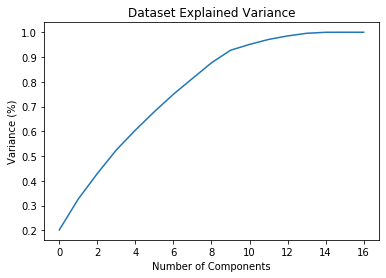

In [30]:
#PCA plotting 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler

#Reading in data 
vehicle_full_df = pd.read_csv('/bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/VehiclesFullCleanedEncoded.csv')
del vehicle_full_df['price']

#Scaling 
scaler = MinMaxScaler(feature_range=[0,1])
scaledData = scaler.fit_transform(vehicle_full_df)

#Fitting the PCA algorithm with our data
pca = PCA().fit(scaledData)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

PCA Plot Analysis 
- can achieve about ~85% using 8 variables 
- can play with the dimension count in model development

# Final preprocessing
- Vectorize features 
- MinMaxScaler (scales data to be between 0-1)
- PCA (principal component analysis)
- Perform test/train split on dataset

In [51]:
from pyspark.ml.feature import VectorAssembler, PCA, MinMaxScaler
#Reading in data 
vehicle_full_df = sqlContext.read.format('csv') \
                                 .options(header='true', inferschema='true') \
                                 .load('file:///bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/VehiclesFullCleanedEncoded.csv')

#Vectorizing 
vectorAssembler = VectorAssembler(inputCols = ['city', 'year', 'manufacturer', 'make', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'county_name', 'state_name'], outputCol = 'features')
vector_vehicle_df = vectorAssembler.transform(vehicle_full_df)
vector_vehicle_df = vector_vehicle_df.select(['features', 'price'])
print("Vectorizing")
vector_vehicle_df.show(5)

#Scaling 
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaledFeatures")
scalerModel = scaler.fit(vector_vehicle_df)
scaledData = scalerModel.transform(vector_vehicle_df)
print("Min Max Scaling")
scaledData.show(5)

#PCA to 10 dimensions for non scaled data
pca = PCA(k = 10, inputCol = "features", outputCol = "pca_features")
model = pca.fit(vector_vehicle_df)
pca_data = model.transform(vector_vehicle_df).select(["features", "price", "pca_features"])
print("PCA")
pca_data.show(5)

#PCA to 10 dimensions for scaled data
pca = PCA(k = 10, inputCol = "scaledFeatures", outputCol = "pca_features")
model = pca.fit(scaledData)
pca_scaled = model.transform(scaledData).select(["features", "price", "pca_features"])
print("PCA Scaled")
pca_scaled.show(5)

#Test/train split 
train_df, test_df = pca_data.randomSplit([0.9, 0.1])
train_df_scaled, test_df_scaled = pca_scaled.randomSplit([0.9, 0.1])
print("Train test split")
print("Original dataframe size: ", vector_vehicle_df.count())
print("Train dataframe size: ", train_df.count())
print("Test dataframe size: ", test_df.count())

Vectorizing
+--------------------+-----+
|            features|price|
+--------------------+-----+
|[222.0,2004.0,18....| 2800|
|[314.0,2010.0,22....| 4480|
|[58.0,2005.0,12.0...| 4500|
|[313.0,2017.0,11....|38500|
|[330.0,2001.0,18....|  800|
+--------------------+-----+
only showing top 5 rows

Min Max Scaling
+--------------------+-----+--------------------+
|            features|price|      scaledFeatures|
+--------------------+-----+--------------------+
|[222.0,2004.0,18....| 2800|[0.50688073394495...|
|[314.0,2010.0,22....| 4480|[0.71788990825688...|
|[58.0,2005.0,12.0...| 4500|[0.13073394495412...|
|[313.0,2017.0,11....|38500|[0.71559633027522...|
|[330.0,2001.0,18....|  800|[0.75458715596330...|
+--------------------+-----+--------------------+
only showing top 5 rows

PCA
+--------------------+-----+--------------------+
|            features|price|        pca_features|
+--------------------+-----+--------------------+
|[222.0,2004.0,18....| 2800|[168587.425928747...|
|[314.0

# Model development/training
- Develop model
    - Linear Regression
    - Decision Tree Regressor
    - Gradient Boosted Tree Regressor
    - Random Forest Regressor 
- Scaling 
    - Will try combinations of with/without scaling 
    - Will try combinations of with/without PCA with various values of k 
- Hyperparameter Tuning
    - Will try different parameters using ParamGridBuilder
    - Will try different folds using CrossValidator
- Evaluation Metrics 
    - RMSE measures differences between predicted values by the model and the actual value
    - R2 indicates % of variability in "price" can be explained by using the model

In [52]:
#Extract small dataset to develop on different algorithms / hyper parameter tuning on local notebook
train_df = train_df.limit(4000)
test_df = test_df.limit(1000)
train_df_scaled = train_df_scaled.limit(4000)
test_df_scaled = test_df_scaled.limit(1000)
print("New sizes. Train: " + str(train_df.count()) + " Test: " + str(test_df.count())) 

New sizes. Train: 4000 Test: 1000


# Creating custom functions for each algorithm 

In [80]:
def my_lr(features, train_df, test_df, grid_dict):
    print("Start time: ", datetime.datetime.now())

    #Prepare grid of parameters to search over
    lr = LinearRegression(featuresCol = features , labelCol='price', maxIter=10)
    paramGrid = ParamGridBuilder() 
    for param in grid_dict:
        paramGrid = paramGrid.addGrid(param, grid_dict[param])
    paramGrid = paramGrid.build()
    
    #Model development/training 
    crossVal = CrossValidator(estimator=lr, 
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="price"),
                              numFolds = 10)
    lr_model = crossVal.fit(train_df)

    #Printing results 
    trainingSummary = lr_model.bestModel.summary
    print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
    print("r2: %f" % trainingSummary.r2)

    lr_predictions = lr_model.transform(test_df)
    lr_predictions.select("prediction","price","pca_features").show(5)
    lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                     labelCol="price",metricName="r2")
    print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

    print("End time: ", datetime.datetime.now())

In [81]:
#Linear Regression, No scaling, PCA 10 variables
grid_dict = { 
    "lr.loss" : ['squaredError', 'huber'], 
    "lr.regParam" : [0.3,0.8,1.0]
}
my_lr("pca_features", train_df, test_df, grid_dict)

Start time:  2019-12-18 10:22:37.992134
RMSE: 8164.466398
r2: 0.544799
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|12239.650526988558|12500|[90996.7325804450...|
| 7148.600848785332| 8900|[131996.727157891...|
| 27683.91217058542|22800|[54196.3118860186...|
|34406.896524749725|38670|[34550.3138344660...|
| 36822.76553586574|45901|[10713.3121965089...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.0279573
End time:  2019-12-18 10:23:37.832595


## R2 very low -> Trying with scaling

In [55]:
#Linear Regression, MinMax Scaled , PCA 10 variables
my_lr("pca_features", train_df_scaled, test_df_scaled, grid_dict)

Start time:  2019-12-11 10:22:01.519169
RMSE: 9574.600386
r2: 0.219303
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|11973.665171749532| 7000|[0.65826988426783...|
|15143.388025951048| 1800|[0.63888637668798...|
|16121.665281561869| 4400|[1.13849252828796...|
| 7359.841432207907| 1600|[0.19629158477099...|
|20485.951557486296|18480|[1.23575976232886...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = -0.085825
End time:  2019-12-11 10:24:33.844277


## R2 is even worse

# Observations 
- Model still not performing well. 
- Dropping geographical data for better correlation?
- Group by year to find better correlation?

In [56]:
vehicle_full_df = pd.read_csv('/bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/VehiclesFullCleanedEncoded.csv')
vehicle_full_df.corr(method='pearson')['price']

Unnamed: 0     -0.000249
city           -0.001180
price           1.000000
year           -0.002290
manufacturer    0.000032
make           -0.003301
condition       0.002162
cylinders       0.000257
fuel           -0.004994
odometer       -0.000184
title_status   -0.001117
transmission   -0.001414
drive           0.001545
size                 NaN
type           -0.002272
paint_color    -0.000134
county_name    -0.000818
state_name      0.001057
Name: price, dtype: float64

In [57]:
#Dropping geographical columns
vehicle_full_df.drop(columns = ['city', 'county_name', 'state_name'], axis = 1, inplace = True)
vehicle_full_df.corr(method='pearson')['price']

Unnamed: 0     -0.000249
price           1.000000
year           -0.002290
manufacturer    0.000032
make           -0.003301
condition       0.002162
cylinders       0.000257
fuel           -0.004994
odometer       -0.000184
title_status   -0.001117
transmission   -0.001414
drive           0.001545
size                 NaN
type           -0.002272
paint_color    -0.000134
Name: price, dtype: float64

In [58]:
#Group by years and check correlation
vehicles_2018 = vehicle_full_df[vehicle_full_df['year'] == 2018]
vehicles_2018.corr(method='pearson')['price']

Unnamed: 0      0.022465
price           1.000000
year                 NaN
manufacturer   -0.091640
make           -0.033123
condition       0.087970
cylinders       0.531479
fuel           -0.286687
odometer       -0.111642
title_status    0.032924
transmission    0.010000
drive           0.410905
size                 NaN
type            0.123198
paint_color    -0.039168
Name: price, dtype: float64

In [59]:
vehicles_2017 = vehicle_full_df[vehicle_full_df['year'] >= 2017]
vehicles_2017.corr(method='pearson')['price']

Unnamed: 0      0.009085
price           1.000000
year            0.200713
manufacturer   -0.087179
make           -0.001474
condition       0.029745
cylinders       0.593349
fuel           -0.374223
odometer       -0.185459
title_status   -0.036422
transmission    0.007561
drive           0.501204
size                 NaN
type            0.117249
paint_color    -0.008416
Name: price, dtype: float64

In [60]:
vehicles_2016 = vehicle_full_df[vehicle_full_df['year'] == 2019]
vehicles_2016.corr(method='pearson')['price']

Unnamed: 0      0.026448
price           1.000000
year                 NaN
manufacturer   -0.312696
make            0.127590
condition       0.560279
cylinders       0.504904
fuel           -0.395002
odometer       -0.547509
title_status    0.051623
transmission   -0.119401
drive           0.219033
size                 NaN
type            0.359621
paint_color    -0.003329
Name: price, dtype: float64

## Higher correlated variables for years: 09, 10, 11, 13, 14, 15, 17, 18, 19
- Create a dataframe with only those years and run models
- Save dataframe to csv file

In [61]:
correlated_df = vehicle_full_df[(vehicle_full_df['year'] >= 2009) & (vehicle_full_df['year'] != 2012) & (vehicle_full_df['year'] >= 2013) & (vehicle_full_df['year'] != 2016)]
correlated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31567 entries, 3 to 135962
Data columns (total 15 columns):
Unnamed: 0      31567 non-null int64
price           31567 non-null int64
year            31567 non-null float64
manufacturer    31567 non-null int64
make            31567 non-null int64
condition       31567 non-null int64
cylinders       31567 non-null int64
fuel            31567 non-null int64
odometer        31567 non-null float64
title_status    31567 non-null int64
transmission    31567 non-null int64
drive           31567 non-null int64
size            31567 non-null int64
type            31567 non-null int64
paint_color     31567 non-null int64
dtypes: float64(2), int64(13)
memory usage: 3.9 MB


In [62]:
correlated_df.drop(columns =['year'], inplace=True)
correlated_df.to_csv('/bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/Correlated_Years.csv')
correlated_df.corr(method='pearson')['price']

/opt/miniconda/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Unnamed: 0      0.004785
price           1.000000
manufacturer   -0.064193
make            0.048280
condition       0.010163
cylinders       0.477328
fuel           -0.259162
odometer       -0.157475
title_status   -0.031031
transmission   -0.021562
drive           0.416348
size                 NaN
type            0.169493
paint_color     0.009456
Name: price, dtype: float64

Preparing data with correlated dataset

In [63]:
from pyspark.ml.feature import VectorAssembler, PCA, MinMaxScaler
#Reading in data 
vehicle_full_df = sqlContext.read.format('csv') \
                                 .options(header='true', inferschema='true') \
                                 .load('file:///bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/Correlated_Years.csv')

#Vectorizing 
vectorAssembler = VectorAssembler(inputCols = ['manufacturer', 'make', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color'], outputCol = 'features')
vector_vehicle_df = vectorAssembler.transform(vehicle_full_df)
vector_vehicle_df = vector_vehicle_df.select(['features', 'price'])
print("Vectorizing")
vector_vehicle_df.show(5)

#Scaling 
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaledFeatures")
scalerModel = scaler.fit(vector_vehicle_df)
scaledData = scalerModel.transform(vector_vehicle_df)
print("Min Max Scaling")
scaledData.show(5)

#PCA to 10 dimensions for non scaled data
pca = PCA(k = 10, inputCol = "features", outputCol = "pca_features")
model = pca.fit(vector_vehicle_df)
pca_data = model.transform(vector_vehicle_df).select(["features", "price", "pca_features"])
print("PCA")
pca_data.show(5)

#PCA to 10 dimensions for scaled data
pca = PCA(k = 10, inputCol = "scaledFeatures", outputCol = "pca_features")
model = pca.fit(scaledData)
pca_scaled = model.transform(scaledData).select(["features", "price", "pca_features"])
print("PCA Scaled")
pca_scaled.show(5)

#Test/train split 
train_df, test_df = pca_data.randomSplit([0.9, 0.1])
train_df_scaled, test_df_scaled = pca_scaled.randomSplit([0.9, 0.1])

#Extract small dataset to develop on different algorithms / hyper parameter tuning on local notebook
train_df = train_df.limit(4000)
test_df = test_df.limit(1000)
train_df_scaled = train_df_scaled.limit(4000)
test_df_scaled = test_df_scaled.limit(1000)
print("New sizes. Train: " + str(train_df.count()) + " Test: " + str(test_df.count())) 
print("Train test split")
print("Original dataframe size: ", vector_vehicle_df.count())
print("Train dataframe size: ", train_df.count())
print("Test dataframe size: ", test_df.count())

Vectorizing
+--------------------+-----+
|            features|price|
+--------------------+-----+
|[11.0,10484.0,2.0...|38500|
|[47.0,7488.0,4.0,...| 8800|
|[12.0,4894.0,2.0,...|15950|
|[11.0,8116.0,4.0,...| 9000|
|[46.0,1310.0,4.0,...|33500|
+--------------------+-----+
only showing top 5 rows

Min Max Scaling
+--------------------+-----+--------------------+
|            features|price|      scaledFeatures|
+--------------------+-----+--------------------+
|[11.0,10484.0,2.0...|38500|[0.20833333333333...|
|[47.0,7488.0,4.0,...| 8800|[0.95833333333333...|
|[12.0,4894.0,2.0,...|15950|[0.22916666666666...|
|[11.0,8116.0,4.0,...| 9000|[0.20833333333333...|
|[46.0,1310.0,4.0,...|33500|[0.9375,0.1010336...|
+--------------------+-----+--------------------+
only showing top 5 rows

PCA
+--------------------+-----+--------------------+
|            features|price|        pca_features|
+--------------------+-----+--------------------+
|[11.0,10484.0,2.0...|38500|[44705.3172187572...|
|[47.0,

In [64]:
#Linear Regression, No scaling, PCA 10 variables
my_lr("pca_features", train_df, test_df, grid_dict)

Start time:  2019-12-11 10:41:40.182096
RMSE: 8164.466433
r2: 0.544799
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|12240.813584920987|12500|[90996.7325804450...|
| 7150.159917954246| 8900|[131996.727157891...|
|27683.736984755844|22800|[54196.3118860186...|
| 34406.04617893581|38670|[34550.3138344660...|
| 36821.69708422516|45901|[10713.3121965089...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.0279587
End time:  2019-12-11 10:44:18.713754


In [82]:
#Linear Regression, MinMax Scaled, PCA 10 variables
my_lr("pca_features", train_df_scaled, test_df_scaled, grid_dict)

Start time:  2019-12-18 10:24:20.200197
RMSE: 24611.578511
r2: 0.078713
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|21937.203859015604| 5500|[-0.0273833626265...|
|30062.813535693567|22800|[-1.1276610783264...|
| 30404.43516447594|38670|[-1.1114344867531...|
| 30196.82864629287|45901|[-1.1192742082906...|
|24396.899851294314|23777|[-0.1832795501158...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.328243
End time:  2019-12-18 10:25:20.121799


## R2 looks better on correlated dataset -> Try different regressions 

# Trying different types of regression
- Decision tree regressor
- Graident-boosted tree regressor
- Random forest regressoor

In [86]:
# Custom functions
#dtr -> decision tree regressor 
def my_dtr(features, train_df, test_df, grid_dict):
    
    print("Start time: ", datetime.datetime.now())
    #Prepare grid of parameters to search over 
    dtr = DecisionTreeRegressor(featuresCol = features , labelCol='price')
    paramGrid = ParamGridBuilder() 
    for param in grid_dict:
        paramGrid = paramGrid.addGrid(param, grid_dict[param])
    paramGrid = paramGrid.build()

    #Model development/training 
    crossVal = CrossValidator(estimator=dtr, 
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="price"),
                              numFolds = 10)
    dtr_model = crossVal.fit(train_df)

    #Make predictions on test data 
    dtr_predictions = dtr_model.transform(test_df)
    dtr_predictions.select('prediction', 'price', 'pca_features').show(5)
    dtr_evaluator = RegressionEvaluator(labelCol="price", metricName="r2")
    r2 = dtr_evaluator.evaluate(dtr_predictions)
    print("R2 on test data = %g" % r2)
    print("Average metrics ", dtr_model.avgMetrics)
    print("Depth of tree:", dtr_model.bestModel.depth)
    print("Extract param map: ", dtr_model.bestModel.extractParamMap)
    print("End time: ", datetime.datetime.now())    

#gbt -> gradient boosted tree
def my_gbt(features, train_df, test_df, grid_dict):
    
    print("Start time: ", datetime.datetime.now())
    #Prepare grid of parameters to search over 
    gbt = GBTRegressor(featuresCol = features, labelCol = 'price', maxIter=10)
    paramGrid = ParamGridBuilder() 
    for param in grid_dict:
        paramGrid = paramGrid.addGrid(param, grid_dict[param])
    paramGrid = paramGrid.build()

    #Model development/training 
    crossVal = CrossValidator(estimator=gbt, 
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="price"),
                              numFolds = 10)
    gbt_model = crossVal.fit(train_df)

    #Make predictions on test data 
    gbt_predictions = gbt_model.transform(test_df)
    gbt_predictions.select('prediction', 'price', 'pca_features').show(5)
    gbt_evaluator = RegressionEvaluator(labelCol="price", metricName="r2")
    r2 = gbt_evaluator.evaluate(gbt_predictions)
    print("R2 on test data = %g" % r2)

    print("End time: ", datetime.datetime.now())    

#rfr -> random forest regressor
def my_rfr(features, train_df, test_df, grid_dict):
    
    print("Start time: ", datetime.datetime.now())
    #Prepare grid of parameters to search over 
    rfr = RandomForestRegressor(featuresCol = features, labelCol = 'price')
    paramGrid = ParamGridBuilder() 
    for param in grid_dict:
        paramGrid = paramGrid.addGrid(param, grid_dict[param])
    paramGrid = paramGrid.build()

    #Model development/training 
    crossVal = CrossValidator(estimator=rfr, 
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="price"),
                              numFolds = 10)
    rfr_model = crossVal.fit(train_df)

    #Make predictions on test data 
    rfr_predictions = rfr_model.transform(test_df)
    rfr_predictions.select('prediction', 'price', 'pca_features').show(5)
    rfr_evaluator = RegressionEvaluator(labelCol="price", metricName="r2")
    r2 = rfr_evaluator.evaluate(rfr_predictions)
    print("R2 on test data = %g" % r2)
    print("Extract param map: ", rfr_model.bestModel.extractParamMap)

    print("End time: ", datetime.datetime.now())

In [87]:
#Decision Tree Regressor, MinMax Scaled , PCA 10 variables
dtr_dict = {
    "dtr.maxDepth": [6,8,10], 
    "dtr.minInfoGain": [0.0, 0.01, 0.05]
}
my_dtr("pca_features", train_df_scaled, test_df_scaled, dtr_dict)

Start time:  2019-12-18 10:35:26.888739
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|           13659.0| 5500|[-0.0273833626265...|
|19180.421487603307|22800|[-1.1276610783264...|
|24334.429936305733|38670|[-1.1114344867531...|
|24334.429936305733|45901|[-1.1192742082906...|
|31559.387516254876|23777|[-0.1832795501158...|
+------------------+-----+--------------------+
only showing top 5 rows

R2 on test data = 0.30352
Average metrics  [22158.81217689547, 22158.81217689547, 22158.81217689547, 22158.81217689547, 22158.81217689547, 22158.81217689547, 22158.81217689547, 22158.81217689547, 22158.81217689547]
Depth of tree: 5
Extract param map:  <bound method Params.extractParamMap of DecisionTreeRegressionModel (uid=DecisionTreeRegressor_4595b6c5df743b2648ac) of depth 5 with 61 nodes>
End time:  2019-12-18 10:37:09.327510


In [97]:
# Decision Tree Regressor, No scaling, PCA 10 variables
my_dtr("pca_features", train_df, test_df, dtr_dict)

Start time:  2019-12-23 14:12:23.746554
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|15418.159459459459|12500|[90996.7325804450...|
|15418.159459459459| 8900|[131996.727157891...|
| 23636.03861003861|22800|[54196.3118860186...|
| 23636.03861003861|38670|[34550.3138344660...|
|42854.704545454544|45901|[10713.3121965089...|
+------------------+-----+--------------------+
only showing top 5 rows

R2 on test data = 0.0376181
Average metrics  [7087.033237769017, 7087.033237769017, 7087.033237769017, 7087.033237769017, 7087.033237769017, 7087.033237769017, 7087.033237769017, 7087.033237769017, 7087.033237769017]
Depth of tree: 5
Extract param map:  <bound method Params.extractParamMap of DecisionTreeRegressionModel (uid=DecisionTreeRegressor_484294e2851bb5994000) of depth 5 with 61 nodes>
End time:  2019-12-23 14:14:04.078268


In [99]:
#Gradient Boosted Tree Regressor, MinMax Scaled,PCA 10 variables
my_gbt("pca_features", train_df_scaled, test_df_scaled, gbt_dict)

Start time:  2019-12-23 14:17:45.553392
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
| 13129.04973298691| 5500|[-0.0273833626265...|
|22477.076202389137|22800|[-1.1276610783264...|
|23102.063732495586|38670|[-1.1114344867531...|
|23604.319772291998|45901|[-1.1192742082906...|
|24933.784823081332|23777|[-0.1832795501158...|
+------------------+-----+--------------------+
only showing top 5 rows

R2 on test data = 0.268637
End time:  2019-12-23 14:39:31.235848


In [100]:
#Gradient Boosted Tree Regressor, No Scaling ,PCA 10 variables
my_gbt("pca_features", train_df, test_df, gbt_dict)

Start time:  2019-12-23 14:39:31.261000
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|13347.645000708219|12500|[90996.7325804450...|
|13347.645000708219| 8900|[131996.727157891...|
|20189.270492510062|22800|[54196.3118860186...|
|30168.376505592347|38670|[34550.3138344660...|
|45129.656365476585|45901|[10713.3121965089...|
+------------------+-----+--------------------+
only showing top 5 rows

R2 on test data = 0.0400846
End time:  2019-12-23 15:01:18.301159


In [89]:
#Random Forest Regressor, MinMax Scaled , PCA 10 variables
rfr_dict = {
    "rfr.impurity": ['variance'], 
    "rfr.maxDepth": [6,8,10], 
    "rfr.minInfoGain": [0.0, 0.01, 0.05]
}
my_rfr("pca_features", train_df_scaled, test_df_scaled, rfr_dict)

Start time:  2019-12-18 11:00:04.215734
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
| 13243.89885509742| 5500|[-0.0273833626265...|
|23629.048419704694|22800|[-1.1276610783264...|
| 21491.60337782774|38670|[-1.1114344867531...|
|21356.724385816466|45901|[-1.1192742082906...|
| 23057.69579872168|23777|[-0.1832795501158...|
+------------------+-----+--------------------+
only showing top 5 rows

R2 on test data = 0.0675366
Extract param map:  <bound method Params.extractParamMap of RandomForestRegressionModel (uid=RandomForestRegressor_4c4380e286062cf60cc2) with 20 trees>
End time:  2019-12-18 11:02:48.515133


In [90]:
#Random Forest Regressor, No scaling, PCA 10 variables
my_rfr("pca_features", train_df, test_df, rfr_dict)

Start time:  2019-12-18 11:02:48.546071
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|15354.458789833388|12500|[90996.7325804450...|
|15100.491434322636| 8900|[131996.727157891...|
| 20878.56936609288|22800|[54196.3118860186...|
| 26076.09066291598|38670|[34550.3138344660...|
| 30910.33527951567|45901|[10713.3121965089...|
+------------------+-----+--------------------+
only showing top 5 rows

R2 on test data = 0.0407094
Extract param map:  <bound method Params.extractParamMap of RandomForestRegressionModel (uid=RandomForestRegressor_443ca207e23ecf0d94e3) with 20 trees>
End time:  2019-12-18 11:05:30.009084


In [91]:
#Model development correlated dataset, Linear regression no scaling, and parambuilder with cross validation
#Linear Regression, No scaling, PCA 10 variables, different hyperparameters 
grid_dict = {
    "lr.regParam": [1.0, 0.7, 0.5, 0.3, 0.1],
    "lr.fitIntercept": [False, True], 
    "lr.elasticNetParam": [0.5, 0.8, 1.0]
}
my_lr("pca_features", train_df, test_df, grid_dict)

Start time:  2019-12-18 11:05:30.035863
RMSE: 8164.466398
r2: 0.544799
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|12239.650526988558|12500|[90996.7325804450...|
| 7148.600848785332| 8900|[131996.727157891...|
| 27683.91217058542|22800|[54196.3118860186...|
|34406.896524749725|38670|[34550.3138344660...|
| 36822.76553586574|45901|[10713.3121965089...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.0279573
End time:  2019-12-18 11:08:34.586758


In [92]:
#Linear Regression, MinMax Scale, PCA 10 variables
my_lr("pca_features", train_df_scaled, test_df_scaled, grid_dict)

Start time:  2019-12-18 11:08:34.621371
RMSE: 24611.578511
r2: 0.078713
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|21937.203859015604| 5500|[-0.0273833626265...|
|30062.813535693567|22800|[-1.1276610783264...|
| 30404.43516447594|38670|[-1.1114344867531...|
| 30196.82864629287|45901|[-1.1192742082906...|
|24396.899851294314|23777|[-0.1832795501158...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.328243
End time:  2019-12-18 11:11:42.861716


In [101]:
#Random Forest Regressor, MinMax Scaled, PCA 10 variables, different hyper parameters 
rfr_dict = {
    "rfr.impurity": ['variance'], 
    "rfr.maxDepth": [10,12,14,20], 
    "rfr.minInfoGain": [0.0, 0.01, 0.05]
}
my_rfr("pca_features", train_df_scaled, test_df_scaled, rfr_dict)

Start time:  2019-12-23 15:01:18.329531
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
| 13243.89885509742| 5500|[-0.0273833626265...|
|23629.048419704694|22800|[-1.1276610783264...|
| 21491.60337782774|38670|[-1.1114344867531...|
|21356.724385816466|45901|[-1.1192742082906...|
| 23057.69579872168|23777|[-0.1832795501158...|
+------------------+-----+--------------------+
only showing top 5 rows

R2 on test data = 0.0675366
Extract param map:  <bound method Params.extractParamMap of RandomForestRegressionModel (uid=RandomForestRegressor_4de487c1256d7914ce5d) with 20 trees>
End time:  2019-12-23 15:04:44.811072


In [102]:
#Random Forest Regressor, No scaling, PCA 10 variables, different hyper parameters 
my_rfr("pca_features", train_df, test_df, rfr_dict)

Start time:  2019-12-23 15:04:44.831472
+------------------+-----+--------------------+
|        prediction|price|        pca_features|
+------------------+-----+--------------------+
|15354.458789833388|12500|[90996.7325804450...|
|15100.491434322636| 8900|[131996.727157891...|
| 20878.56936609288|22800|[54196.3118860186...|
| 26076.09066291598|38670|[34550.3138344660...|
| 30910.33527951567|45901|[10713.3121965089...|
+------------------+-----+--------------------+
only showing top 5 rows

R2 on test data = 0.0407094
Extract param map:  <bound method Params.extractParamMap of RandomForestRegressionModel (uid=RandomForestRegressor_4825a7807b12be6547b7) with 20 trees>
End time:  2019-12-23 15:08:10.806291


# Final Summary on Small Dataset
- Linear Regression: 32% (MinMax Scaled with PCA)
- Decision Tree: 27%, (MinMax scaling with PCA) 
- Gradient Boosted: 30% (MinMax scaling with PCA)
- Random Forest: 6% (Scaled with PCA)

Next steps: 
- Develop models using best configurations for each algorithm on training cluster 
- Save models in project repo

In [ ]:
%%sparktraining --pyspark

#running all models on training cluster and saving the models to project repo 
#Note: different random split of data will yield different accuracy score than shown in notebook here 
import datetime 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor, RandomForestRegressor

print("Start time: ", datetime.datetime.now())

#Reading in data 
vehicle_full_df = sqlContext.read.format('csv') \
                                 .options(header='true', inferschema='true') \
                                 .load('file:///bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/Correlated_Years.csv')

#Vectorizing 
vectorAssembler = VectorAssembler(inputCols = ['manufacturer', 'make', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color'], outputCol = 'features')
vector_vehicle_df = vectorAssembler.transform(vehicle_full_df)
vector_vehicle_df = vector_vehicle_df.select(['features', 'price'])

#Scaling 
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaledFeatures")
scalerModel = scaler.fit(vector_vehicle_df)
scaledData = scalerModel.transform(vector_vehicle_df)

#PCA to 10 dimensions for non scaled data
pca = PCA(k = 10, inputCol = "features", outputCol = "pca_features")
model = pca.fit(vector_vehicle_df)
pca_data = model.transform(vector_vehicle_df).select(["features", "price", "pca_features"])

#PCA to 10 dimensions for scaled data
pca = PCA(k = 10, inputCol = "scaledFeatures", outputCol = "pca_features")
model = pca.fit(scaledData)
pca_scaled = model.transform(scaledData).select(["features", "price", "pca_features"])

#Test/train split 
train_df, test_df = pca_data.randomSplit([0.9, 0.1])
train_df_scaled, test_df_scaled = pca_scaled.randomSplit([0.9, 0.1])

#-----------------------------------------------------Linear Regression
lr = LinearRegression(maxIter=100, labelCol='price') 
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [1.0, 0.7, 0.5, 0.3, 0.1]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.5, 0.8, 1.0])\
    .build()

#Model development/training
crossVal = CrossValidator(estimator=lr, 
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="price"),
                          numFolds = 10)

lr_model = crossVal.fit(train_df)
lr_model.bestModel.save('file:///bd-fs-mnt/Spark_RA3/models/Spark_Vehicles/lr_model.model')
#-----------------------------------------------------Decision Tree 
dtr = DecisionTreeRegressor(featuresCol = 'pca_features' , labelCol='price')
paramGrid = ParamGridBuilder()\
    .addGrid(dtr.maxDepth, [6,8,10])\
    .addGrid(dtr.minInfoGain, [0.0, 0.01, 0.05])\
    .build()

#Model development/training 
crossVal = CrossValidator(estimator=dtr, 
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="price"),
                          numFolds = 10)
dtr_model = crossVal.fit(train_df_scaled)
dtr_model.bestModel.save('file:///bd-fs-mnt/Spark_RA3/models/Spark_Vehicles/dtr_model.model')
#-----------------------------------------------------Gradient Boosted Tree
gbt = GBTRegressor(featuresCol = 'pca_features', labelCol = 'price', maxIter=10)
paramGrid = ParamGridBuilder()\
    .addGrid(gbt.lossType, ['squared', 'absolute'])\
    .addGrid(gbt.impurity, ['variance'])\
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.2])\
    .addGrid(gbt.minInfoGain, [0.0, 0.01, 0.05])\
    .build()

#Model development/training 
crossVal = CrossValidator(estimator=gbt, 
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="price"),
                          numFolds = 10)
gbt_model = crossVal.fit(train_df_scaled)
gbt_model.bestModel.save('file:///bd-fs-mnt/Spark_RA3/models/Spark_Vehicles/gbt_model.model')

print("End time: ", datetime.datetime.now())

In [ ]:
%%sparktraining --pyspark

#running random forest model separately because of longer training times
import datetime 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor, RandomForestRegressor

print("Start time: ", datetime.datetime.now())

#Reading in data 
vehicle_full_df = sqlContext.read.format('csv') \
                                 .options(header='true', inferschema='true') \
                                 .load('file:///bd-fs-mnt/Spark_RA3/data/Craigslist_Vehicles/Correlated_Years.csv')

#Vectorizing 
vectorAssembler = VectorAssembler(inputCols = ['manufacturer', 'make', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color'], outputCol = 'features')
vector_vehicle_df = vectorAssembler.transform(vehicle_full_df)
vector_vehicle_df = vector_vehicle_df.select(['features', 'price'])

#Scaling 
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaledFeatures")
scalerModel = scaler.fit(vector_vehicle_df)
scaledData = scalerModel.transform(vector_vehicle_df)

#PCA to 10 dimensions for non scaled data
pca = PCA(k = 10, inputCol = "features", outputCol = "pca_features")
model = pca.fit(vector_vehicle_df)
pca_data = model.transform(vector_vehicle_df).select(["features", "price", "pca_features"])

#PCA to 10 dimensions for scaled data
pca = PCA(k = 10, inputCol = "scaledFeatures", outputCol = "pca_features")
model = pca.fit(scaledData)
pca_scaled = model.transform(scaledData).select(["features", "price", "pca_features"])

#Test/train split 
train_df, test_df = pca_data.randomSplit([0.9, 0.1])
train_df_scaled, test_df_scaled = pca_scaled.randomSplit([0.9, 0.1])

#-----------------------------------------------------Random Forest

#Prepare grid of parameters to search over 
rfr = RandomForestRegressor(featuresCol = 'pca_features', labelCol = 'price')
paramGrid = ParamGridBuilder()\
    .addGrid(rfr.impurity, ['variance'])\
    .addGrid(rfr.maxDepth, [12,16,20])\
    .addGrid(rfr.minInfoGain, [0.0, 0.01, 0.05])\
    .build()

#Model development/training 
crossVal = CrossValidator(estimator=rfr, 
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="price"),
                          numFolds = 10)
rfr_model = crossVal.fit(train_df)
rfr_model.bestModel.save('file:///bd-fs-mnt/Spark_RA3/models/Spark_Vehicles/rfr_model.model')

print("End time: ", datetime.datetime.now())

In [ ]:
rfr_predictions.select('prediction').collect()[0]['prediction']

In [ ]:
'''
Next steps:
Try different preprocessing steps. Maybe include more feature variables(years?)
Some car names have extra characters like "-c300" 
'''